In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import seaborn as sns
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


from tensorflow.keras.preprocessing import image
#from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
TRAIN_DIR = "/Users/Mareikes/Desktop/Wahlpflicht_AI/projekt_emotions/emotion_dataset_v2/datasets/train"


In [ ]:
from pathlib import Path
OUT_DIR = Path("../output") # Zielpfad relativ zum Skript
OUT_DIR.mkdir(parents=True, exist_ok=True)  # Ordner erstellen, falls er noch nicht existiert

### Training

In [4]:
batch_sizes = [16, 32, 64]
img_height = 256
img_width = 256

In [5]:
# Speichern der Ergebnisse für jede Batchgröße
history_dicts = {}

for batch_size in batch_sizes:
    print(f"Training with batch_size={batch_size}")
    
    # Trainings- und Validierungsdaten mit der aktuellen Batch-Größe laden
    train_ds = tf.keras.utils.image_dataset_from_directory(
        TRAIN_DIR,
        validation_split=0.1,
        subset="training",
        seed=42,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        labels='inferred',
        label_mode='int',
        shuffle=True
    )
    
    val_ds = tf.keras.utils.image_dataset_from_directory(
        TRAIN_DIR,
        validation_split=0.1,
        subset="validation",
        seed=42,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        labels='inferred',
        label_mode='int',
        shuffle=True
    )
    
    class_names = np.array(train_ds.class_names)
    num_classes = len(class_names)

    AUTOTUNE = tf.data.AUTOTUNE
    
    # Dataset-Optimierung
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

    #Augmentation, nicht zu viel, Gesichter sollen erkennbar bleiben
    data_augmentation = tf.keras.Sequential([
        keras.Input(shape=(img_height, img_width, 3)),
        
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        ])
    
    # Modell erstellen (wird für jede Batch-Größe separat kompiliert)
    model = Sequential([
        layers.Input(shape=(img_height, img_width, 3)),
        data_augmentation,
        layers.Rescaling(1./255),
        layers.Conv2D(16, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes)
    ])
    
    #callback early stopping
    early_stopping = EarlyStopping(
    monitor='val_loss',    # Überwacht die Validierungs-Fehler
    patience=5,           # Stoppt Training, wenn sich 5 Epochen lang nichts verbessert #beim nächsten Mal!!
    restore_best_weights=True  # Lädt die besten Gewichte automatisch
    )

    #callback Überwachung lernrate
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',    # Überwacht die Validierungs-Fehler
        factor=0.5,            # Halbiert die Lernrate
        patience=5,            # Nach 5 Epochen ohne Verbesserung
        min_lr=1e-6            # Untere Grenze der Lernrate
    )

    # callback zum speichern
    out_path = OUT_DIR / f'cnn_v2_{batch_size}.keras'
    checkpoint = ModelCheckpoint(
        out_path,                     # speicherort/name
        monitor='val_loss',           # überwacht den Validation Loss
        save_best_only=True,          # nur speichern, wenn sich das Modell verbessert
        mode='min',                   # niedrigere val_loss ist besser
        save_weights_only=False       # speichert das ganze Modell, nicht nur Gewichte
    )

    #kompilieren, optimizer, loss und Metriken bestimmen
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    
    model.summary()
    
    # Training des Modells
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=40,
        callbacks=[early_stopping, reduce_lr, checkpoint]
    )
    
    # Speichern des History-Dictionaries
    history_dicts[batch_size] = history.history




Training with batch_size=16
Found 3149 files belonging to 2 classes.
Using 2835 files for training.
Found 3149 files belonging to 2 classes.
Using 314 files for validation.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     8,388,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,412,578 (32.09 MB)

 Trainable params: 8,412,578 (32.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 46s 243ms/step - accuracy: 0.5286 - loss: 0.8528 - val_accuracy: 0.5860 - val_loss: 0.6788 - learning_rate: 0.0010
Epoch 2/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 46s 258ms/step - accuracy: 0.6206 - loss: 0.6509 - val_accuracy: 0.6433 - val_loss: 0.7212 - learning_rate: 0.0010
Epoch 3/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 53s 298ms/step - accuracy: 0.6681 - loss: 0.6385 - val_accuracy: 0.6879 - val_loss: 0.5932 - learning_rate: 0.0010
Epoch 4/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 60s 336ms/step - accuracy: 0.6957 - loss: 0.5737 - val_accuracy: 0.7006 - val_loss: 0.5629 - learning_rate: 0.0010
Epoch 5/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 63s 356ms/step - accuracy: 0.7147 - loss: 0.5492 - val_accuracy: 0.7102 - val_loss: 0.5334 - learning_rate: 0.0010
Epoch 6/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 59s 334ms/step - accuracy: 0.7323 - loss: 0.5293 - val_accuracy: 0.7771 - val_loss: 0.4996 - learning_rate: 0.0010
Epoch 7/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 61s 342ms/step - accuracy: 0.7

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 256, 256, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     8,388,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,412,578 (32.09 MB)

 Trainable params: 8,412,578 (32.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
89/89 ━━━━━━━━━━━━━━━━━━━━ 59s 630ms/step - accuracy: 0.5221 - loss: 0.8360 - val_accuracy: 0.5510 - val_loss: 0.6800 - learning_rate: 0.0010
Epoch 2/40
89/89 ━━━━━━━━━━━━━━━━━━━━ 59s 662ms/step - accuracy: 0.5943 - loss: 0.6702 - val_accuracy: 0.6210 - val_loss: 0.6612 - learning_rate: 0.0010
Epoch 3/40
89/89 ━━━━━━━━━━━━━━━━━━━━ 59s 659ms/step - accuracy: 0.6247 - loss: 0.6403 - val_accuracy: 0.6529 - val_loss: 0.6221 - learning_rate: 0.0010
Epoch 4/40
89/89 ━━━━━━━━━━━━━━━━━━━━ 58s 656ms/step - accuracy: 0.6672 - loss: 0.6073 - val_accuracy: 0.6783 - val_loss: 0.5841 - learning_rate: 0.0010
Epoch 5/40
89/89 ━━━━━━━━━━━━━━━━━━━━ 60s 671ms/step - accuracy: 0.7049 - loss: 0.5729 - val_accuracy: 0.7484 - val_loss: 0.5447 - learning_rate: 0.0010
Epoch 6/40
89/89 ━━━━━━━━━━━━━━━━━━━━ 59s 665ms/step - accuracy: 0.7363 - loss: 0.5210 - val_accuracy: 0.7611 - val_loss: 0.4657 - learning_rate: 0.0010
Epoch 7/40
89/89 ━━━━━━━━━━━━━━━━━━━━ 63s 709ms/step - accuracy: 0.7612 - loss: 0.

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 256, 256, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     8,388,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,412,578 (32.09 MB)

 Trainable params: 8,412,578 (32.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.4975 - loss: 2.3675 - val_accuracy: 0.5573 - val_loss: 0.6815 - learning_rate: 0.0010
Epoch 2/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.5730 - loss: 0.6686 - val_accuracy: 0.5987 - val_loss: 0.6695 - learning_rate: 0.0010
Epoch 3/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.6069 - loss: 0.6510 - val_accuracy: 0.6210 - val_loss: 0.6384 - learning_rate: 0.0010
Epoch 4/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.6340 - loss: 0.6273 - val_accuracy: 0.6083 - val_loss: 0.6518 - learning_rate: 0.0010
Epoch 5/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.6597 - loss: 0.6143 - val_accuracy: 0.7357 - val_loss: 0.5759 - learning_rate: 0.0010
Epoch 6/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.6982 - loss: 0.5770 - val_accuracy: 0.6242 - val_loss: 0.6240 - learning_rate: 0.0010
Epoch 7/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.6910 - loss: 0.5883 - val_accuracy: 

### Trainingsverlauf visualisieren

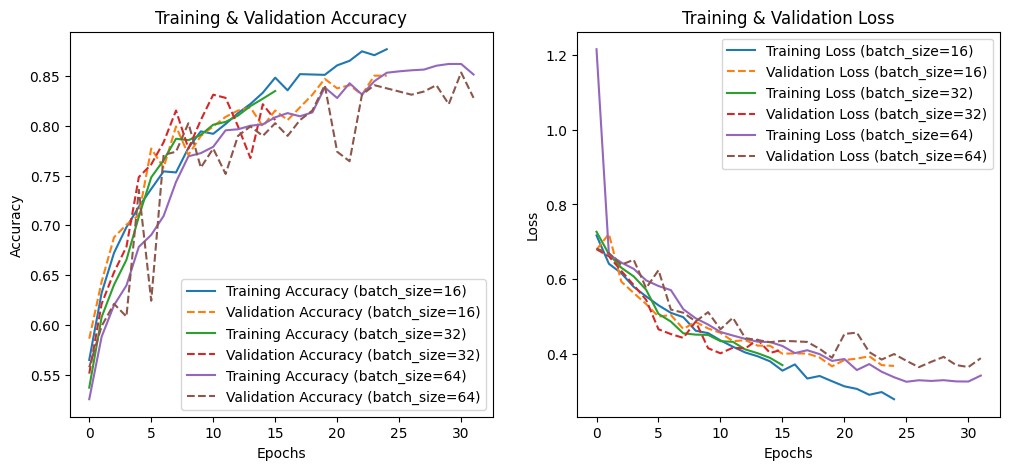

In [6]:
plt.figure(figsize=(12, 5))

# Training und Validation Accuracy für jede Batch-Größe plotten
plt.subplot(1, 2, 1)
for batch_size in batch_sizes:
    plt.plot(history_dicts[batch_size]['accuracy'], label=f'Training Accuracy (batch_size={batch_size})')
    plt.plot(history_dicts[batch_size]['val_accuracy'], label=f'Validation Accuracy (batch_size={batch_size})', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title(f'Training & Validation Accuracy')
plt.legend()

# Training und Validation Loss für jede Batch-Größe plotten
plt.subplot(1, 2, 2)
for batch_size in batch_sizes:
    plt.plot(history_dicts[batch_size]['loss'], label=f'Training Loss (batch_size={batch_size})')
    plt.plot(history_dicts[batch_size]['val_loss'], label=f'Validation Loss (batch_size={batch_size})', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Training & Validation Loss')
plt.legend()

plt.show()

### Evaluierung

In [7]:
TEST_DIR = "/Users/Mareikes/Desktop/Wahlpflicht_AI/projekt_emotions/emotion_dataset_v2/datasets/test"


=== Evaluating model with batch_size=16 ===
Found 788 files belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

2025-05-20 17:59:33.345461: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


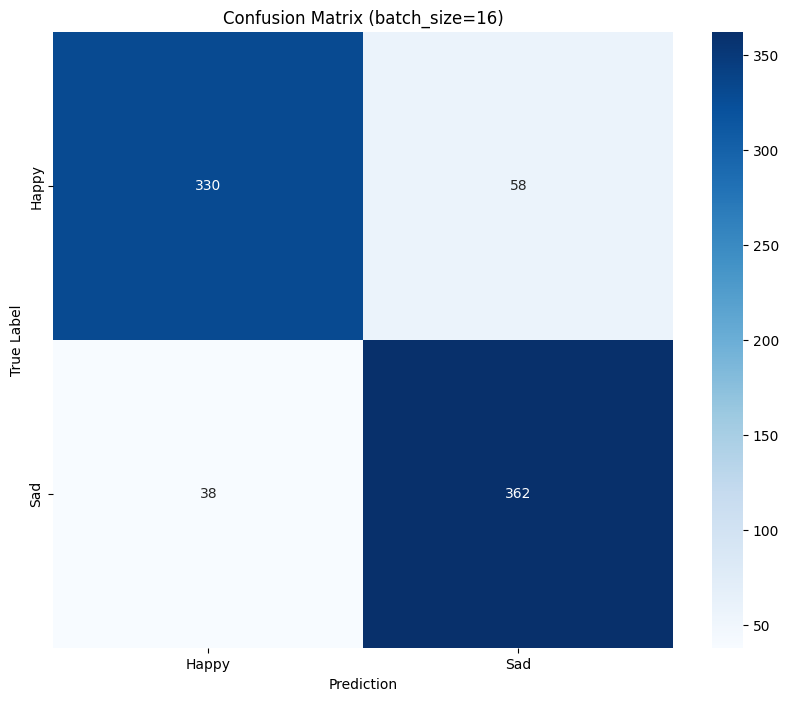

              precision    recall  f1-score   support

       Happy       0.90      0.85      0.87       388
         Sad       0.86      0.91      0.88       400

    accuracy                           0.88       788
   macro avg       0.88      0.88      0.88       788
weighted avg       0.88      0.88      0.88       788

Macro-F1-Score (batch_size=16): 0.8780

=== Evaluating model with batch_size=32 ===
Found 788 files belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1

2025-05-20 17:59:40.970385: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


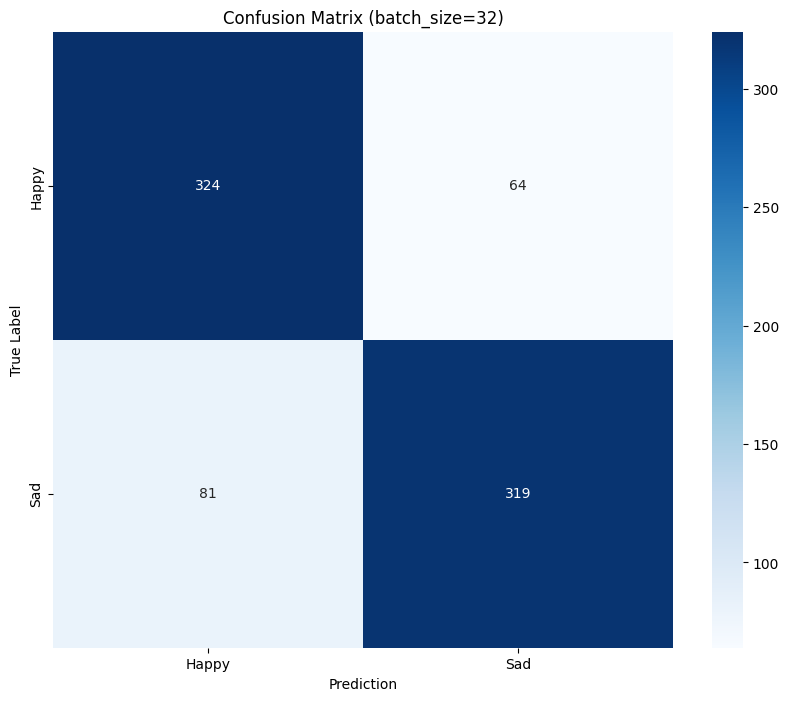

              precision    recall  f1-score   support

       Happy       0.80      0.84      0.82       388
         Sad       0.83      0.80      0.81       400

    accuracy                           0.82       788
   macro avg       0.82      0.82      0.82       788
weighted avg       0.82      0.82      0.82       788

Macro-F1-Score (batch_size=32): 0.8160

=== Evaluating model with batch_size=64 ===
Found 788 files belonging to 2 classes.
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 321ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


2025-05-20 17:59:47.944135: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


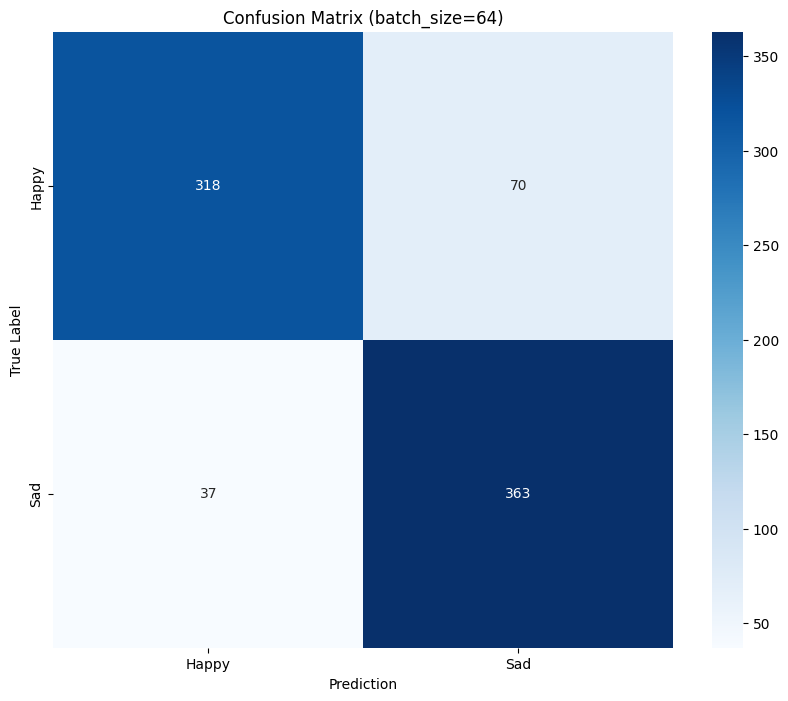

              precision    recall  f1-score   support

       Happy       0.90      0.82      0.86       388
         Sad       0.84      0.91      0.87       400

    accuracy                           0.86       788
   macro avg       0.87      0.86      0.86       788
weighted avg       0.87      0.86      0.86       788

Macro-F1-Score (batch_size=64): 0.8638

=== F1-Score-Vergleich ===
Batch Size 16: F1-Score = 0.8780
Batch Size 32: F1-Score = 0.8160
Batch Size 64: F1-Score = 0.8638

Bestes Modell basierend auf F1-Score: Batch Size 16 mit Score 0.8780


In [9]:
# Parameter
batch_sizes = [16, 32, 64]
img_height = 256
img_width = 256


# Funktion zur Visualisierung der Confusion Matrix
def show_confusion_matrix(cm, labels, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, xticklabels=labels, yticklabels=labels,
                annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()

# Dictionary zum Speichern der F1-Scores
f1_scores = {}

# Evaluierung für jede batch_size
for batch_size in batch_sizes:
    print(f"\n=== Evaluating model with batch_size={batch_size} ===")
    
    # Modell laden
    model = load_model(f'cnn_v2_{batch_size}.keras')
    
    # Testdaten laden
    test_ds = tf.keras.utils.image_dataset_from_directory(
        TEST_DIR,
        seed=42,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        labels='inferred',
        label_mode='int',
        shuffle=False
    )
    class_names = np.array(test_ds.class_names)

    # Vorhersagen & Labels sammeln
    all_labels = []
    all_preds = []

    for images, labels in test_ds:
        preds = model.predict(images)
        pred_classes = tf.argmax(preds, axis=-1)
        all_labels.extend(labels.numpy())
        all_preds.extend(pred_classes.numpy())

    # Confusion Matrix & Klassifikationsbericht
    cm = confusion_matrix(all_labels, all_preds)
    show_confusion_matrix(cm, class_names, title=f'Confusion Matrix (batch_size={batch_size})')
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # F1-Score berechnen
    f1 = f1_score(all_labels, all_preds, average='macro')  # 'macro' = gleichgewichteter Durchschnitt über Klassen
    f1_scores[batch_size] = f1
    print(f"Macro-F1-Score (batch_size={batch_size}): {f1:.4f}")

# Vergleich der F1-Scores
print("\n=== F1-Score-Vergleich ===")
for bsz, score in f1_scores.items():
    print(f"Batch Size {bsz}: F1-Score = {score:.4f}")

# Bestes Modell bestimmen
best_batch_size = max(f1_scores, key=f1_scores.get)
print(f"\nBestes Modell basierend auf F1-Score: Batch Size {best_batch_size} mit Score {f1_scores[best_batch_size]:.4f}")

### Vorhersagen

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


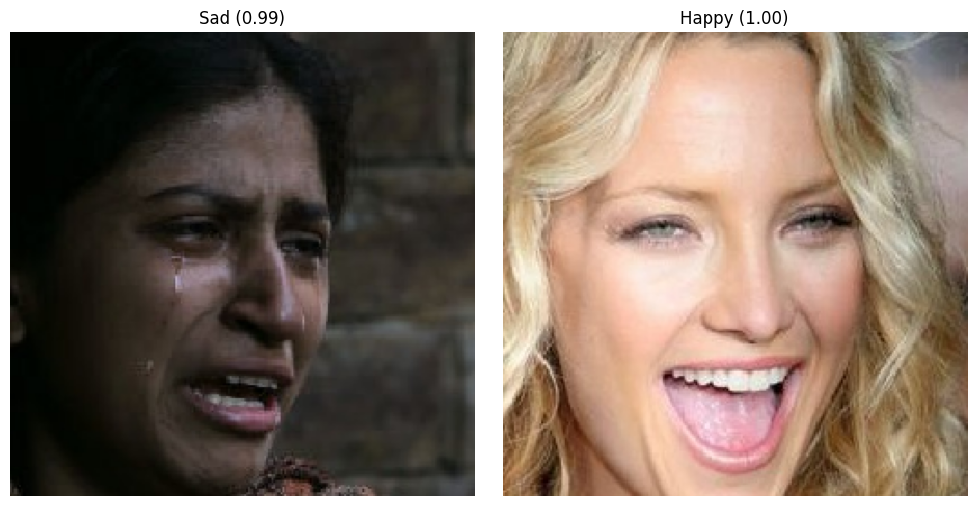

In [49]:
# Bildgröße
img_height, img_width = 256, 256

# Beste batch_size aus vorherigem Schritt
best_batch_size = best_batch_size

# Modell laden
model = load_model(f'cnn_v2_{best_batch_size}.keras')

# Zwei zufällige Bilder auswählen
image_paths = []
for root, _, files in os.walk(TEST_DIR):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(root, file))

image_paths = np.random.choice(image_paths, 2, replace=False)

# Visualisierung mit Vorhersage
plt.figure(figsize=(10, 5))
for i, path in enumerate(image_paths):
    img = image.load_img(path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)

    logits = model.predict(img_batch)
    probabilities = tf.nn.softmax(logits[0]).numpy()

    predicted_class = np.argmax(probabilities)
    confidence = probabilities[predicted_class]

    plt.subplot(1, 2, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"{class_names[predicted_class]} ({confidence:.2f})")
plt.tight_layout()
plt.show()
